<a href="https://colab.research.google.com/github/appletreeleaf/Study_Log/blob/ML/%5BHW13%5D_Polynomial_Regression_%26_Regularization_%EC%9D%B4%EC%9E%AC%EC%98%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [HW13] Polynomial Regression & Regularization


지난번 시간까지는 linear 한 관계에 대해서 알아보았습니다. linear 한 관계란, 데이터를 가장 잘 설명해주는 **직선**을 찾는 것이었습니다. 하지만 우리의 데이터가 x,y 좌표에서 직선의 형태가 아닌 구부러진 형태로 되어있다면 linear 말고 다른 방법을 찾아야 할 것입니다.

그래서 이번 시간에는 polynomial regression을 실습을 통해서 알아보도록 하겠습니다. 그리고 regularization을 통해서 어떻게 학습이 변화되는지 알아보겠습니다.

이제부터 코드를 통해서 알아보도록 하겠습니다.


## 1.1 A special case of multiple linear regression

먼저 우리는 4차 polynomial function
$$y = x^4 + x^3 - 4x^2$$
을 이용해서 데이터를 생성해보도록 하겠습니다. 이전에 했던 것처럼 noise를 추가해서 생성하도록 하겠습니다.

In [ ]:
from matplotlib import pyplot
from autograd import grad
from autograd import numpy

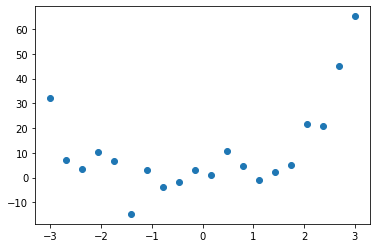

In [ ]:
numpy.random.seed(0)    # fix seed for reproducibility
x = numpy.linspace(-3, 3, 20)
y = x**4 + x**3 - 4*x**2 + 8*numpy.random.normal(size=len(x)) # noise
pyplot.scatter(x, y);

우리가 생성한 데이터는 곡선의 형태이기 때문에 직선으로 표현하는데에는 무리가 있습니다.

그래서 우리는 polynomial function을 사용해서 표현하도록 하겠습니다. 이제 먼저 $d$ 차 곡선을 정의해보겠습니다.

$$\hat{y} = w_0 + w_1x + w_2x^2 + ... + w_dx^d$$

$w$는 우리가 찾아야 할 계수들입니다. 우리는 주어진 $x, y$를 가장 잘 설명해줄 수 있는 $w$를 찾는 것이 목적입니다.

이제 우리는 위의 식을 조금 변형하여 linear regression 문제처럼 바꾸어 보겠습니다. $x_i = x^i$라고 정의를 하면 다음과 같이 나타낼 수 있습니다.

$$\hat{y} = w_0 + w_1x_1 + w_2x_2 + ... + w_dx_d$$

이제 polynomial regression 문제가 multiple linear regression 문제와 동일해졌습니다. 이것도 또한 이전에 한 것처럼 행렬의 형태로 나타낼 수 있습니다.

$$\hat{\mathbf{y}} = \begin{bmatrix}
\hat{y}^{(1)}  \\
\hat{y}^{(2)}\\
\vdots  \\
\hat{y}^{(N)}
\end{bmatrix} =
\begin{bmatrix}
x_0^{(1)} &  x_1^{(1)} & \cdots & x_d^{(1)} \\
x_0^{(2)} &  x_1^{(2)} & \cdots & x_d^{(2)} \\
\vdots & \vdots & \ddots & \vdots \\
x_0^{(N)} &  x_1^{(N)} & \cdots & x_d^{(N)}
\end{bmatrix} \begin{bmatrix}
w_0  \\
w_1\\
\vdots  \\
w_d
\end{bmatrix}
= \mathbf{X}\mathbf{w}$$

이번 실습에서 3차항까지 고려해서 실습을 진행하도록 하겠습니다.

코드로 살펴보겠습니다.

In [ ]:
degree = 3

def polynomial_features(x, degree):
    """ Generate polynomial features for x."""

    X = numpy.empty((len(x), degree+1)) # matrix X (절편을 위한 1 포함)
    for i in range(degree+1):
        X[:,i] = x**i  #x^1, x^2, x^3, x^4
    return X

X = polynomial_features(x, degree)
print(X.shape)

(20, 4)


## 1.2 Scale the data, train the model

이제 기존에 했던 것처럼 입력 변수들을 정규화 시켜주고, 학습을 진행해보도록 하겠습니다. 이번에는 scikit-learn 패키지 안에 있는 min max sclaer 를 사용하겠습니다.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
X_scaled[:,0] = 1   # the column for intercept

이제 [HW12]에서 했던대로 학습을 진행해보겠습니다.

In [ ]:
def linear_regression(params, X):
    '''
    The linear regression model in matrix form.
    Arguments:
      params: 1D array of weights for the linear model
      X     : 2D array of input values
    Returns:
      1D array of predicted values
    '''
    return numpy.dot(X, params) # return y_hat array

def mse_loss(params, model, X, y):
    '''
    The mean squared error loss function.
    Arguments:
      params: 1D array of weights for the linear model
      model : function for the linear regression model
      X     : 2D array of input values
      y     : 1D array of predicted values
    Returns:
      float, mean squared error
    '''
    y_pred = model(params, X) # 가중치 벡터와 X 행렬연산 결과 즉 y_hat
    return numpy.mean( numpy.sum((y-y_pred)**2) ) # mean squared error

gradient = grad(mse_loss)

In [ ]:
max_iter = 3000 # 반복횟수
alpha = 0.01  # learning rate
params = numpy.zeros(X_scaled.shape[1]) #[0,0,0,0]
descent = numpy.ones(X_scaled.shape[1]) #[[1,1,1,1],[1,1,1,1].....[1,1,1,1]] 20 by 4
i = 0

from sklearn.metrics import mean_absolute_error

while numpy.linalg.norm(descent) > 0.01 and i < max_iter: #
    descent = gradient(params, linear_regression, X_scaled, y)
    params = params - descent * alpha # Gradient Descent
    loss = mse_loss(params, linear_regression, X_scaled, y)
    mae = mean_absolute_error(y, X_scaled@params)
    if i%100 == 0:
        print("iteration {}, loss = {}, mae = {}, descent = {}".format(i, loss, mae, descent))
    i += 1

iteration 0, loss = 5434.767518111348, mae = 11.05718775676392, descent = [-440.61657842 -318.28269089 -340.6219872  -294.08485328]
iteration 100, loss = 1300.4768479787672, mae = 6.885099348931476, descent = [ 4.50740415 -0.80308025 -4.05150992 -4.63308682]
iteration 200, loss = 1281.308959359777, mae = 6.8639053389713665, descent = [ 0.58771205  1.65158974 -0.17306376 -2.66766759]
iteration 300, loss = 1272.9896965024661, mae = 6.807943451695349, descent = [ 0.33560885  1.46466886 -0.01329299 -2.12152744]
iteration 400, loss = 1267.4477500708404, mae = 6.760476747247461, descent = [ 0.26750785  1.20182352 -0.0051277  -1.73032021]
iteration 500, loss = 1263.7497451381248, mae = 6.721622404779564, descent = [ 0.21821512  0.98198239 -0.00392735 -1.41332528]
iteration 600, loss = 1261.282144135704, mae = 6.689879731162117, descent = [ 0.17823976  0.80216472 -0.00319618 -1.15449943]
iteration 700, loss = 1259.6355657998567, mae = 6.663949878547802, descent = [ 0.14559834  0.655266   -0.00

이제 학습된 parameter들을 보겠습니다.

In [ ]:
params #loss를 최소화시키는 가중치들

array([-22.51572398,   6.75930601,  41.30788709,  30.0105898 ])

원래 데이터와 함께 그래프로 표현해서 보겠습니다.

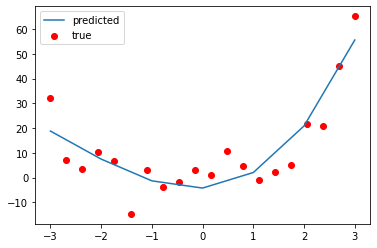

In [ ]:
xgrid = numpy.linspace(x.min(), x.max(), 7)
Xgrid_poly_feat = polynomial_features(xgrid, degree)
Xgrid_scaled = min_max_scaler.transform(Xgrid_poly_feat)
Xgrid_scaled[:,0] = 1
pyplot.scatter(x, y, c='r', label='true')
pyplot.plot(xgrid, Xgrid_scaled@params, label='predicted')
pyplot.legend();

## 1.3 Observe underfitting & overfitting

우리는 위에서 모델을 만들 때 3차항으로 설정을 한 뒤 학습을 진행하였습니다. 과연 3차항으로 설정한 것이 좋은 선택이었을까요?

지금부터 우리는 1부터 15까지 다양한 차수를 가지고 학습을 하면서 변화를 지켜보겠습니다. 우리는 ipywidget 패키지를 통해서 어떻게 변화하는지 보겠습니다.

In [ ]:
from urllib.request import urlretrieve
URL = 'https://raw.githubusercontent.com/engineersCode/EngComp6_deeplearning/master/scripts/plot_helpers.py'
urlretrieve(URL, 'plot_helpers.py')

('plot_helpers.py', <http.client.HTTPMessage at 0x7f9ab36d64f0>)

In [ ]:
from plot_helpers import interact_polyreg

max_degree = 15
interact_polyreg(max_degree, x, y)

interactive(children=(IntSlider(value=8, description='degree', max=15, min=1), Output()), _dom_classes=('widge…

### 1.3.1 Underfitting

위 셀에서 degree를 1로 설정을 하면 우리의 데이터와 가장 잘 맞는 직선을 찾아줍니다.

직선은 너무 간단해서 데이터가 흩뿌려져 있을 때는 그 데이터를 잘 설명하지 못합니다.

이것을 **underfitting** 되었다고 합니다. Underfitting 에서는 우리의 예측 값이 **high bias, low variance**의 성질을 가지게 됩니다.

Bias, variance 의 개념을 이해하기 쉽게 예시를 들어서 설명해보겠습니다.



<img src="https://lh3.googleusercontent.com/rq_iMVSuIK1K4ykF9RQnF05hH6xxWm3lmNPWuQ3hfK9r4-3GBIuCxCW3L7QH53M3EIwbVWOcaRiRLDc0AIJ-0uq8-qzavpSWPceQ1lchq-ZPF16l3KLst24-x6MbGYFqQbEJmEI3gEc
" width="500" height="400" />

Underfitting 되었다면 low variance, high bias이기 때문에 저 위의 4개의 과녁에서 왼쪽 아래의 과녁에 해당됩니다.

예측값들이 한군데에 몰려있어서 low variance이지만, 정답에서 멀기 때문에 high bias 인 것입니다.

우리가 모델을 낮은 차수로 설정했다면, 그것은 직선에 가까워지고, 그렇다면 예측 값들은 직선의 근처에서만 나오기 때문에 low variance입니다. 그리고 직선은 흩뿌려진 데이터를 정확히 예측할 수 없기 때문에 정답에서 멀게 되고, high bias가 되는 것입니다.


### 1.3.2 Overfitting

이제 degree를 높게 설정해 보겠습니다. Training error인 MAE 값이 점점 감소합니다. 그러면 degree가 제일 큰 15가 MAE값이 가장 작으니까 제일 잘 맞는 모델일까요? 아닙니다!!

오른쪽으로 degree를 움직일수록 우리의 모델이 곡선을 이루면서 모든 training point를 지나게 됩니다. 하지만 이제 새로운 데이터가 들어오게 된다면 어떻게 될까요? Training data를 모두 커버하려고 매우 복잡하기 때문에 새로운 데이터를 잘 못 맞추게 됩니다. 예를 들어 위에서 degree 15 일 때 맨 오른 쪽 두 점 가운데로 새로운 데이터가 들어온다면, 기존의 데이터들과 매우 비슷한 데이터이지만 우리의 모델은 매우 큰 값을 예측하게 되어 큰 오류 값을 가지게 됩니다.

이것을 우리는 **overfitting**이라고 부르고, **high variance, low bias**이기 때문에 위 과녁 그림 예시에서 오른쪽 위에 해당하게 됩니다.

Overfitting 은 training 과정에서는 작은 에러를 가지기에 찾아내기가 힘듭니다. 이제부터는 regularization을 통해서 overfitting을 막는 방법을 알아보겠습니다.



## 1.4 Regularization

Regularization은 overfitting 을 막는 방법입니다. Cost function에서 새로운 식을 추가해서 복잡한 모델이 되는 것을 막아주게 됩니다. 먼저 우리의 기존 모델은 다음과 같습니다.

$$\hat{y} = w_0 + w_1x + w_2x^2 + ... + w_dx^d$$

차수를 가진 항들이 모델을 복잡하게 만듭니다. 그래서 그들의 계수값에 제한 조건을 추가합니다.

보편적인 방법은 regularization term 인 $\lambda\sum_{j=1}^dw_j^2$를 추가하는 것 입니다. Mean-squared error를 사용한 cost function에 추가하면 다음과 같습니다.

$$L(\mathbf{w}) = \frac{1}{N} \lVert \mathbf{y} - \mathbf{Xw} \rVert^2 + \lambda \sum_{j=1}^d w_j^2$$

새롭게 만든 cost function은 계수들이 작은 값이 되는 것을 선호하게 됩니다. 왜냐하면 계수들이 커지게 되면 두번째 항이 커지게 돼서 cost 값이 늘어나게 되기 때문입니다.

위 식에서 $\lambda$는 regularization parameter 입니다. 우리가 얼마나 큰 제약을 줄 것인가를 결정하게 됩니다. $\lambda$가 큰 값을 가질수록 계수들을 더 작게 할 수 있습니다.

이번 실습에서는 $\lambda$값을 1로 설정하겠습니다.


In [ ]:
def regularized_loss(params, model, X, y, _lambda=1.0):
    '''
    The mean squared error loss function with an L2 penalty.
    Arguments:
      params: 1D array of weights for the linear model / 가중치 벡터
      model : function for the linear regression model / 모형 선택
      X     : 2D array of input values / features
      y     : 1D array of predicted values / target
      _lambda: regularization parameter, default 1.0 / regularization
    Returns:
      float, regularized mean squared error
    '''
    y_pred = model(params, X)
    return numpy.mean( numpy.sum((y-y_pred)**2) ) + _lambda * numpy.sum( params[1:]**2 )

gradient = grad(regularized_loss)

In [ ]:
no_regularization_params = params.copy()

In [ ]:
max_iter = 3000
alpha = 0.01
params = numpy.zeros(X_scaled.shape[1])
descent = numpy.ones(X_scaled.shape[1])
i = 0

from sklearn.metrics import mean_absolute_error

while numpy.linalg.norm(descent) > 0.01 and i < max_iter:
    descent = gradient(params, linear_regression, X_scaled, y)
    params = params - descent * alpha
    loss = mse_loss(params, linear_regression, X_scaled, y)
    mae = mean_absolute_error(y, X_scaled@params)
    if i%100 == 0:
        print("iteration {}, loss = {}, mae = {}".format(i, loss, mae))
    i += 1

iteration 0, loss = 5434.767518111348, mae = 11.05718775676392
iteration 100, loss = 1785.9852202374184, mae = 6.983886996350374
iteration 200, loss = 1764.2597057711018, mae = 6.966518785947395
iteration 300, loss = 1763.5702631188328, mae = 6.965728405272657


In [ ]:
zeros = numpy.array([[1, 0, 0, 0]])

In [ ]:
params.shape

(4,)

이제 regularization을 추가한 것과 추가하지 않은 것을 비교해보겠습니다.

weights without regularization
[-22.51572398   6.75930601  41.30788709  30.0105898 ]
weights with regularization
[-11.13750882  12.48522096  28.26626633  11.09211867]


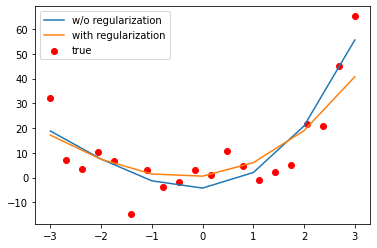

In [ ]:
print("weights without regularization")
print(no_regularization_params)
print("weights with regularization")
print(params)

pyplot.scatter(x, y, c='r', label='true')
pyplot.plot(xgrid, Xgrid_scaled@no_regularization_params, label='w/o regularization')
pyplot.plot(xgrid, Xgrid_scaled@params, label='with regularization')
pyplot.legend();

더 다양한 차수에서 regularization을 비교해 보겠습니다.

In [ ]:
interact_polyreg(max_degree, x, y, regularized=True)

interactive(children=(IntSlider(value=8, description='degree', max=15, min=1), Output()), _dom_classes=('widge…

Degree가 커질수록 regularization의 중요성이 들어나게 됩니다. 이제 높은 차수에서 예측 모델이 이리저리 움직이는 모습이 아닌 부드럽게 학습 데이터들을 지나가는 모습을 볼 수 잇습니다. 이렇게 된다면 새롭게 들어오는 데이터도 잘 예측할 수 있게 될 것입니다.
직관적으로 말하면, 구불구불한 그래프를 부드러운 곡선 형태로 바꿔줍니다. 따라서 overfitting을 방지할 수 있겠군요.

이번 시간에는 polynomial regression과 regularization에 대해서 알아보았습니다. 다음시간에는 실제 데이터에서의 multiple logistic regression을 알아보고, regularization을 추가해보는 실습을 진행해보도록 하겠습니다.